In [65]:
#Map package
import gpxpy

#Data wrangling
import pandas as pd
import numpy as np

#visualization
import folium
import matplotlib.pyplot as plt

In [66]:
with open('pdtr_main_loop.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    
#min and max in meters of gpx data
min_elevation, max_elevation = gpx.get_elevation_extremes()
#getting the total ascent and descent in meters
uphill, down_hill = gpx.get_uphill_downhill()

In [67]:
# Extract track points (latitude, longitude, elevation)
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append((point.latitude, point.longitude, point.elevation))

# You can then convert these points into a Pandas DataFrame for easier manipulation
df = pd.DataFrame(points, columns=['latitude', 'longitude', 'elevation'])

In [71]:
#combining copies since the race is two loops
df2 = df.copy()
combined = pd.concat([df, df2], axis=0).reset_index(drop=True)

In [73]:
combined

,latitude,longitude,elevation
0,34.97869,-101.67844,889.27
1,34.97897,-101.67924,889.32
2,34.97893,-101.67926,889.32
3,34.97901,-101.67947,889.45
4,34.97907,-101.67958,889.51
...,...,...,...
3019,34.97882,-101.67780,887.08
3020,34.97876,-101.67799,887.78
3021,34.97869,-101.67811,888.42
3022,34.97864,-101.67827,889.16


In [5]:
from geopy.distance import geodesic

# Method 1: Using shift() - most efficient
def calculate_segment_distances(df):
    # Get previous row coordinates using shift()
    prev_coords = list(zip(df['latitude'].shift(1), df['longitude'].shift(1)))
    curr_coords = list(zip(df['latitude'], df['longitude']))
    
    distances = []
    for i, (curr, prev) in enumerate(zip(curr_coords, prev_coords)):
        if i == 0 or pd.isna(prev[0]):  # First row has no previous
            distances.append(0.0)
        else:
            distances.append(geodesic(prev, curr).kilometers)
    
    return distances

# Calculate distances between consecutive points
combined['segment_distance'] = calculate_segment_distances(combined)
combined['total_distance'] = combined['segment_distance'].cumsum()

In [6]:
# Check the results
print(f"Total distance: {combined['total_distance'].iloc[-1]:.2f} km")
print(f"Number of segments: {len(combined) - 1}")
print("\nFirst few rows:")
print(combined[['latitude', 'longitude', 'segment_distance', 'total_distance']].head())

Total distance: 49.39 km
Number of segments: 3023

First few rows:
   latitude  longitude  segment_distance  total_distance
0  34.97869 -101.67844          0.000000        0.000000
1  34.97897 -101.67924          0.079380        0.079380
2  34.97893 -101.67926          0.004799        0.084178
3  34.97901 -101.67947          0.021130        0.105308
4  34.97907 -101.67958          0.012050        0.117358


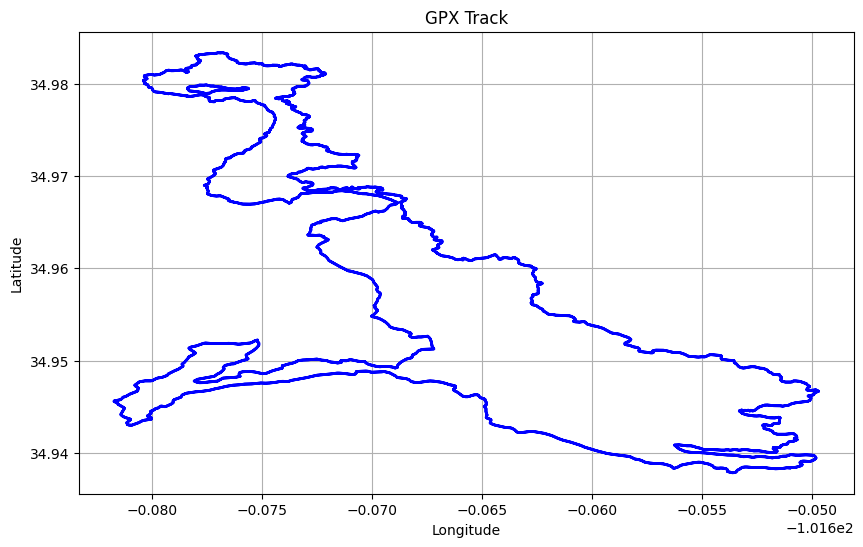

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(combined['longitude'], combined['latitude'], color='blue', linewidth=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPX Track')
plt.grid(True)
plt.show()

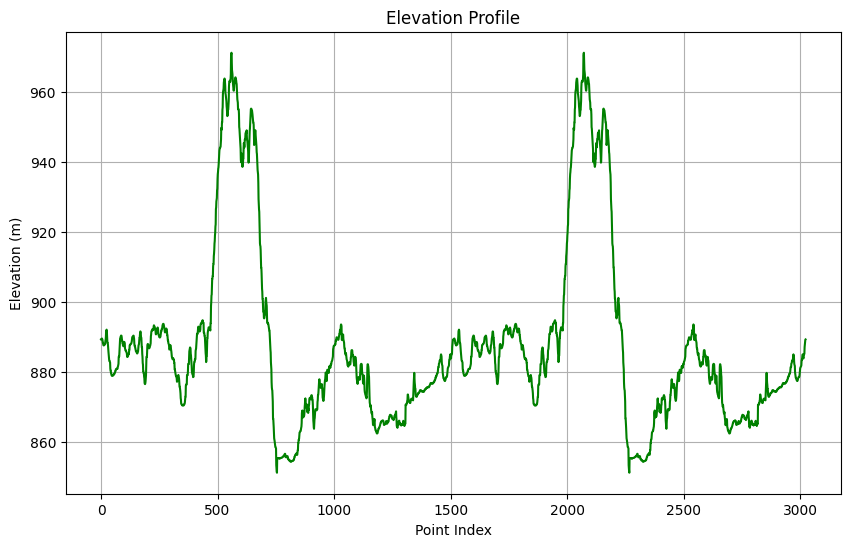

In [8]:

# To plot elevation profile
plt.figure(figsize=(10, 6))
plt.plot(combined.index, combined['elevation'], color='green')
plt.xlabel('Point Index')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile')
plt.grid(True)
plt.show()

In [9]:

combined['rounded_distance'] = combined['total_distance'].round(decimals=0).astype(int)

In [10]:
# Find the row index closest to each whole kilometer
def find_kilometer_markers(df):
    """
    For each whole kilometer, find the row index that has the closest total_distance
    """
    max_distance = int(df['total_distance'].max()) + 1
    kilometer_markers = {}
    
    for km in range(max_distance):
        # Find the index of the row closest to this kilometer
        differences = np.abs(df['total_distance'] - km)
        closest_idx = differences.idxmin()
        kilometer_markers[km] = closest_idx
    
    return kilometer_markers

# Get the kilometer markers
km_markers = find_kilometer_markers(combined)

# Create a column that indicates if this row is a kilometer marker
combined['is_km_marker'] = 0
combined['km_number'] = np.nan

# Mark the kilometer marker rows
for km, row_idx in km_markers.items():
    combined.loc[row_idx, 'is_km_marker'] = 1
    combined.loc[row_idx, 'km_number'] = km

In [11]:
# Function to calculate bearing between two GPS points
import math

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing (direction) from point 1 to point 2
    Returns bearing in degrees (0-360)
    """
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    
    y = math.sin(dlon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    
    bearing = math.atan2(y, x)
    bearing = math.degrees(bearing)
    bearing = (bearing + 360) % 360  # Convert to 0-360 range
    
    return bearing

def create_arrow_icon(color, rotation):
    """
    Create a custom HTML/CSS arrow icon for better directional visualization
    """
    return folium.DivIcon(
        html=f'''
        <div style="
            width: 0; 
            height: 0; 
            border-left: 8px solid transparent;
            border-right: 8px solid transparent;
            border-bottom: 20px solid {color};
            transform: rotate({rotation}deg);
            transform-origin: 8px 12px;
        "></div>
        ''',
        icon_size=(16, 16),
        icon_anchor=(8, 12)
    )

# Now you can use this for various analyses:
# 1. Add kilometer markers to your map with directional arrows
m2 = folium.Map(location=[combined['latitude'].mean(), combined['longitude'].mean()], zoom_start=12)

# Add the main track
folium.PolyLine(combined[['latitude', 'longitude']].values, color='red', weight=2.5, opacity=1).add_to(m2)

# Add markers for start and end points (optional)
folium.Marker([combined['latitude'].iloc[0], combined['longitude'].iloc[0]], popup='Start/End').add_to(m2)

# Add kilometer markers with directional arrows
km_marker_rows = combined[combined['is_km_marker'] == 1].copy()

for i, (index, row) in enumerate(km_marker_rows.iterrows()):
    # Calculate bearing to next point (look ahead for smoother direction)
    look_ahead = 5
    if look_ahead > 0:
        next_point_idx = index + look_ahead
        bearing = calculate_bearing(
            row['latitude'], row['longitude'],
            combined.iloc[next_point_idx]['latitude'], combined.iloc[next_point_idx]['longitude']
        )
        
        # Color coding: blue for first loop, green for second loop
        color = 'blue' if row['total_distance'] <= 24 else 'green'
        
        # Create custom arrow marker
        arrow_icon = create_arrow_icon(color, bearing)
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            icon=arrow_icon,
            popup=f"KM {int(row['km_number'])}<br>Distance: {row['total_distance']:.3f} km<br>Elevation: {row['elevation']:.1f} m<br>Bearing: {bearing:.1f}°"
        ).add_to(m2)
    else:
        # For the last point, use a circle marker since there's no next point
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=8,
            popup=f"KM {int(row['km_number'])}<br>Distance: {row['total_distance']:.3f} km<br>Elevation: {row['elevation']:.1f} m<br>FINISH",
            color='red',
            fillColor='red',
            fillOpacity=0.8
        ).add_to(m2)

# Display the map with directional arrows
m2.save('my_map.html')

In [ ]:
#calculating grade per km segment
combined['km_number'] = combined['km_number'].ffill()
grade_per_km = combined.groupby('km_number')['elevation'].agg(['first', 'last'])
grade_per_km['elevation_change'] = grade_per_km['last'] - grade_per_km['first']
grade_per_km['grade'] = grade_per_km['elevation_change'] / 1.0  # since it's per km, divide by 1 km
grade_per_km.reset_index(inplace=True)
#Calculate the grade between each point
combined = combined.merge(grade_per_km[['km_number', 'grade']], on='km_number', how='left', suffixes=('', '_per_km'))

#segment gain 
combined['segment_gain'] = combined['elevation'].diff()

In [53]:
#creating function to calculate pace over each segment
def calculate_pace(base_pace, current_distance, grade, total_race_distance, decay: bool = False, hill_mode: bool = False):
    """
    Estimate pace (minutes per km) based on segment distance and grade.
    Uses logarithmic decay for more realistic fatigue modeling.
    """
    # pace is min/km
    adjusted_pace = base_pace
    
    if decay:
        # Logarithmic decay - pace slows down more after halfway point
        halfway_point = total_race_distance / 2

        if current_distance <= halfway_point:
            early_decay = 0.05 * math.log(1 + current_distance/halfway_point)
        else:
            progress_beyond_halfway = (current_distance - halfway_point)
            early_decay = 0.05 * math.log(2) + 0.2 * math.log(1 + progress_beyond_halfway)

        adjusted_pace += early_decay  # ADD to make pace slower

    if hill_mode and grade > 0 and grade < 20:
        # Hill adjustment - pace decreases based on positive grade
        grade_factor = 0.08  # pace decreases by 0.08 min/km for every 1% increase in grade
        adjusted_pace += grade_factor * grade
    elif hill_mode and grade >= 20:
        grade_factor = 0.12  # pace decreases by 0.12 min/km for every 1% increase in grade
        adjusted_pace += grade_factor * grade
        adjusted_pace = min(adjusted_pace, 12.5) #ensure pace doesn't exceed equivalent of 20 min/mile
    
    return adjusted_pace

# Get total race distance for decay calculation
total_race_distance = combined['total_distance'].max()

# Example usage with logarithmic decay:
base_pace = 6.2  # base pace in min/km (adjust to your target pace)
combined['pace'] = combined.apply(
    lambda row: calculate_pace(
        base_pace, 
        row['total_distance'], 
        row['grade'], 
        total_race_distance,
        decay=False, 
        hill_mode=True
    ), 
    axis=1
)

In [55]:
# Calculate segment times and cumulative time
combined['segment_time'] = combined['segment_distance'] * combined['pace']  # time in minutes
combined['cumulative_time'] = combined['segment_time'].cumsum()

# Convert cumulative time to hours:minutes:seconds format
def minutes_to_hms(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    secs = int((minutes % 1) * 60)
    return f"{hours:02d}:{mins:02d}:{secs:02d}"

combined['cumulative_time_hms'] = combined['cumulative_time'].apply(minutes_to_hms)

# Show pace progression
print("Pace and Time Analysis:")
print(f"Total race distance: {total_race_distance:.2f} km")
print(f"Estimated finish time: {combined['cumulative_time_hms'].iloc[-1]}")
print(f"Average pace: {combined['pace'].mean():.2f} min/km")
print()

# Show pace at key points
km_markers_with_pace = combined[combined['is_km_marker'] == 1][
    ['km_number', 'total_distance', 'pace', 'grade', 'cumulative_time_hms']
].head(10)
print("Pace breakdown by kilometer:")
print(km_markers_with_pace.to_string(index=False))

Pace and Time Analysis:
Total race distance: 49.39 km
Estimated finish time: 05:35:25
Average pace: 6.87 min/km

Pace breakdown by kilometer:
 km_number  total_distance    pace  grade cumulative_time_hms
       0.0        0.000000  6.2000  -4.96            00:00:00
       1.0        0.996468  6.7664   7.08            00:06:10
       2.0        2.000897  6.2040   0.05            00:12:58
       3.0        3.001584  6.2000 -14.71            00:19:10
       4.0        4.000015  7.5256  16.57            00:25:23
       5.0        5.000005 11.5784  44.82            00:32:56
       6.0        6.002758 10.2932  34.11            00:44:32
       7.0        7.005865  6.2000 -24.05            00:54:44
       8.0        8.007013  6.2000 -20.00            01:00:57
       9.0        9.001993  6.2000 -66.12            01:07:07


In [62]:
def convert_to_mph(pace_min_per_km):
    """Convert pace from min/km to min/mile"""
    return pace_min_per_km * 1.60934

def convert_to_kmh(pace_min_per_mile):
    """Convert pace from min/mile to min/km"""
    return pace_min_per_mile / 1.60934

print(f"\nKey insights:")
print(f"• Pace at start: {combined['pace'].iloc[0]:.2f} min/km or {convert_to_mph(combined['pace'].iloc[0]):.2f} min/mile")
print(f"• Pace at halfway ({total_race_distance/2:.1f}km): {combined[combined['total_distance'] >= total_race_distance/2]['pace'].iloc[0]:.2f} min/km or {convert_to_mph(combined[combined['total_distance'] >= total_race_distance/2]['pace'].iloc[0]):.2f} min/mile")
print(f"• Pace at finish: {combined['pace'].iloc[-1]:.2f} min/km or {convert_to_mph(combined['pace'].iloc[-1]):.2f} min/mile")
print(f"• Total elevation gain: {combined['segment_gain'][combined['segment_gain'] > 0].sum():.1f} m")


Key insights:
• Pace at start: 6.20 min/km or 9.98 min/mile
• Pace at halfway (24.7km): 6.66 min/km or 10.71 min/mile
• Pace at finish: 7.06 min/km or 11.37 min/mile
• Total elevation gain: 815.5 m
